In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd

In [3]:
global N_total
N_total = 100
alpha_damage_propagation = 0.062
coupling_factor = 0.089
mortality_rate = 4.3*(10**(-4))
disease_rate = 0.02

@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total**2))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1

        else: 
            died = True

        t+=τ
    return np.array([t,N, died]) 

#@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):

    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
        if X[i][2]:
            break
    return X

x0 = np.array([0., 0., False])

num_cel = 1*(10**4) #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,50000.,2.)) for i in tqdm(range(num_cel))])

100%|██████████| 10000/10000 [01:07<00:00, 147.42it/s]


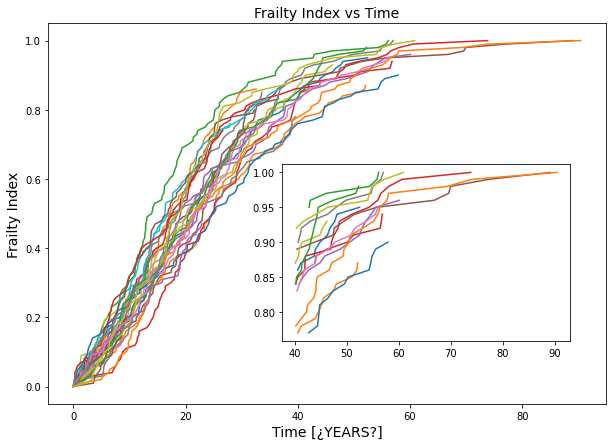

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
zoom_region = [0.45, 0.25, 0.4, 0.35]

fig, ax = plt.subplots(figsize = (10,7))
ax_zoom = plt.axes(zoom_region)
for i in range(1,30):
    indice = np.argmax(celulas[i][:, 2] == 1)
    ax.plot(celulas[i][:indice][:,0]/100, celulas[i][:indice][:,1]/100)
    ax_zoom.plot(celulas[i][2000:indice][:,0]/100, celulas[i][2000:indice][:,1]/100)
ax.set_xlabel("Time [¿YEARS?]", fontsize = 14)
ax.set_ylabel("Frailty Index", fontsize = 14)
ax.set_title("Frailty Index vs Time", fontsize = 14)
plt.savefig("Gillespie_patterns.jpg", dpi = 500)
plt.show()


In [23]:
import numpy as np
from tqdm import tqdm

rango_edades = np.arange(1, 121, 1)
behaviour_frailty = np.empty_like(rango_edades, dtype=object)

for idx, edad in enumerate(tqdm(rango_edades)):
    rango_min = edad - 0.2
    rango_max = edad + 0.2

    indices = np.where((celulas[:, :, 0] / 100 >= rango_min) & (celulas[:, :, 0] / 100 <= rango_max))
    valores = celulas[indices[0], indices[1], 1]
    behaviour_frailty[idx] = valores

100%|██████████| 100/100 [22:01<00:00, 13.21s/it]


In [25]:
curva_promedio = []
for i in behaviour_frailty:
    promedio = np.mean(i)
    curva_promedio.append(promedio)

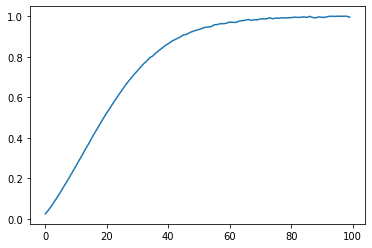

In [28]:
curva_promedio = np.array(curva_promedio)
plt.plot(curva_promedio/100)

(array([0.00622478, 0.        , 0.00638576, 0.01357646, 0.        ,
        0.05790118, 0.11124109, 0.25763072, 0.3862046 , 0.41083541]),
 array([ 92. ,  92.8,  93.6,  94.4,  95.2,  96. ,  96.8,  97.6,  98.4,
         99.2, 100. ]),
 <BarContainer object of 10 artists>)

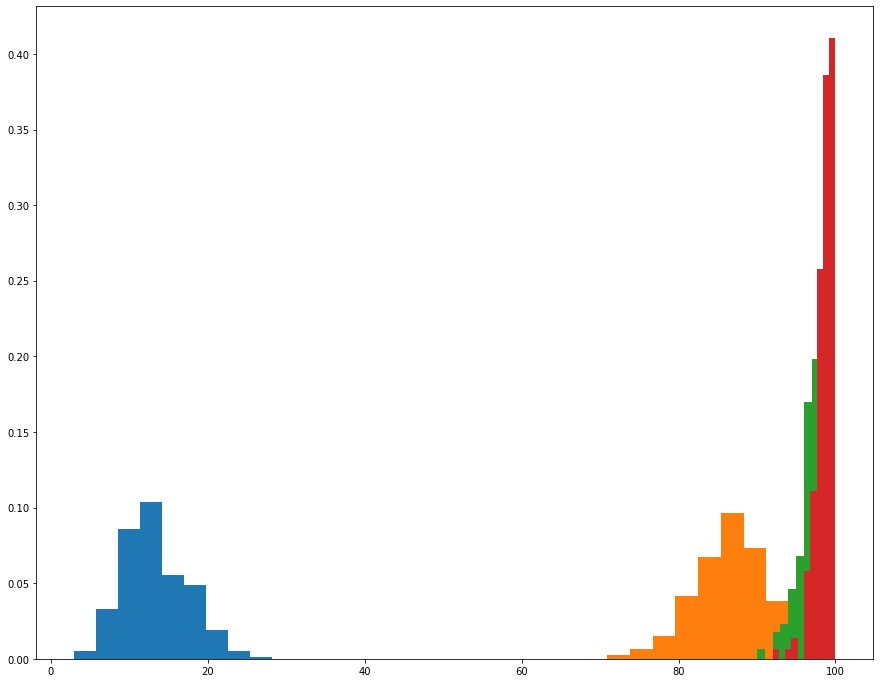

In [118]:
informacion_20 = behaviour_frailty[5]
informacion_40 = behaviour_frailty[40]
informacion_60 = behaviour_frailty[60]
informacion_100 = behaviour_frailty[70]
plt.figure(figsize=(15,12))
plt.hist(informacion_20, density=True)
plt.hist(informacion_40, density=True)
plt.hist(informacion_60, density=True)
plt.hist(informacion_100, density=True)

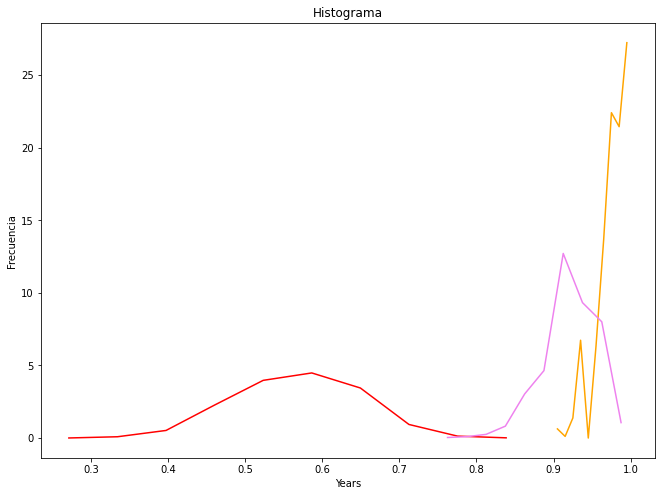

In [94]:
hist_1, bins_1 = np.histogram(np.concatenate((behaviour_frailty[20:25]/100)), density=True)
hist_2, bins_2 = np.histogram(np.concatenate((behaviour_frailty[60:65]/100)), density=True)
hist_3, bins_3 = np.histogram(np.concatenate((behaviour_frailty[80:85]/100)), density=True)
hist_4, bins_4 = np.histogram(np.concatenate((behaviour_frailty[45:50]/100)), density=True)


# Obtener los puntos medios de cada bin
bin_centers_1 = 0.5 * (bins_1[:-1] + bins_1[1:])
bin_centers_2 = 0.5 * (bins_2[:-1] + bins_2[1:])
bin_centers_3 = 0.5 * (bins_3[:-1] + bins_3[1:])
bin_centers_4 = 0.5 * (bins_4[:-1] + bins_4[1:])

# Visualizar el histograma como una línea
plt.figure(figsize=(11,8))
plt.plot(bin_centers_1, hist_1, '-', color = "red")
plt.plot(bin_centers_2, hist_2, '-', color = "orange")
#plt.plot(bin_centers_3, hist_3, '-', color = "green")
plt.plot(bin_centers_4, hist_4, '-', color = "violet")

#plt.scatter(bin_centers, hist )
plt.xlabel('Years')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.show()

(array([ 0.62923256,  0.11317575,  1.38332749,  6.73764754,  0.        ,
         6.32677037, 13.70902761, 22.41371887, 21.44987975, 27.23722006]),
 array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 10 artists>)

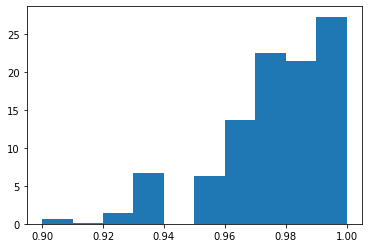

In [75]:
plt.hist(np.concatenate((behaviour_frailty[60:65]/100)), density=True, bins = 10)

# Estadisticas

In [ ]:
ventana_de_busqueda_1 = np.array([20,25])
ventana_de_busqueda_2 = np.array([50,55])
ventana_de_busqueda_3 = np.array([70,75])
ventana_de_busqueda_4 = np.array([95,100])

In [5]:
tiempos = []
for i in tqdm(range(1,len(celulas))):
    indice = np.argmax(celulas[i][:, 2] == 1)
    tiempo_muerte = celulas[i][indice,0]
    tiempos.append(tiempo_muerte)
tiempos = np.array(tiempos)

100%|██████████| 9999/9999 [00:03<00:00, 2579.14it/s]


(array([ 13.,  29.,  74.,  91., 163., 169., 233., 251., 311., 328., 389.,
        410., 407., 399., 411., 419., 433., 404., 413., 373., 352., 362.,
        303., 275., 259., 236., 225., 195., 178., 185., 127., 146., 125.,
        140., 110., 112.,  93.,  64.,  68.,  61.,  65.,  47.,  54.,  40.,
         40.,  42.,  37.,  26.,  22.,  33.,  26.,  29.,  21.,  16.,   9.,
         13.,  12.,  14.,  10.,   9.,   9.,  11.,   7.,   7.,   6.,   5.,
          7.,   2.,   7.,   0.,   4.,   3.,   7.,   3.,   1.,   5.,   1.,
          2.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,   1.,
          2.]),
 array([  0.67835538,   2.93485883,   5.19136227,   7.44786572,
          9.70436917,  11.96087262,  14.21737607,  16.47387951,
         18.73038296,  20.98688641,  23.24338986,  25.49989331,
         27.75639676,  30.0129002 ,  32.26940365,  34.5259071 ,
         36.78241055,  39.038914  ,  41.29541745,  43.55192089

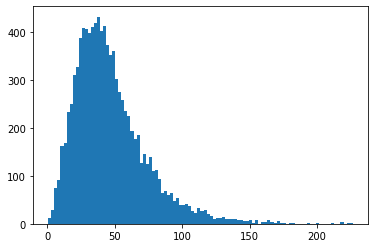

In [10]:
plt.hist(tiempos/100, bins = 100)

In [11]:
datos = tiempos/100

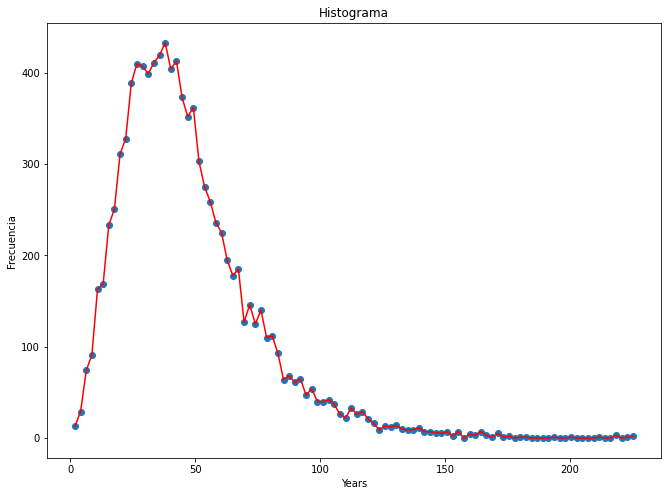

In [31]:
hist, bins = np.histogram(datos, bins=100)

# Obtener los puntos medios de cada bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Visualizar el histograma como una línea
plt.figure(figsize=(11,8))
plt.plot(bin_centers, hist, '-', color = "red")
plt.scatter(bin_centers, hist )
plt.xlabel('Years')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.show()

In [ ]:
N = 0
N_total = 100
tiempos = np.arange(0.,50000.,2.)
tmax = tiempos[]
while t < tmax and not died :
    s_1 =  ((N_total-N)/(N_total**2))*(alpha_damage_propagation*N + disease_rate*N_total)
    s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
    S_T = s_1 + s_2 

    τ = (-1/S_T)*np.log(np.random.rand())
    x = np.random.rand()

    if x <= (s_1)/S_T:
        N += 1

    else: 
        died = True

    t+=τ

In [123]:
print("hola")

hola


In [129]:
plt.hist(celulas[:,:,0])

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9c5a64a040> (for post_execute):


KeyboardInterrupt: 